<a href="https://colab.research.google.com/github/ashdtsc/AI-ML-Learning-/blob/main/Convolution_NN_for_image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

***Classifying Cat and Dog Images***

In [1]:
# Load libraries
import os
import shutil
import pathlib
import zipfile
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from tensorflow import keras

In [3]:
# Download the dogs-vs-cats dataset
from kaggle.api.kaggle_api_extended import KaggleApi
api = KaggleApi()
api.authenticate()


download_path = os.path.join(os.getcwd(), 'kaggle_datasets')
os.makedirs(download_path, exist_ok= True)

api.competition_download_files('dogs-vs-cats', path = download_path)


In [4]:
zip_file = os.path.join(download_path, 'dogs-vs-cats.zip')

# unzipping mail zip file
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall(download_path)

#  Unzip all nested zip files (e.g., test1.zip, train.zip)
for file in os.listdir(download_path):
    if file.endswith('.zip'):
        zip_path = os.path.join(download_path, file)
        try:
            with zipfile.ZipFile(zip_path, 'r') as zip_ref:
                zip_ref.extractall(download_path)
            print(f"Unzipped {file}")
        except zipfile.BadZipFile:
            print(f"Error: {file} is not a valid zip file")

# Step 3: Clean up zip files
for file in os.listdir(download_path):
    if file.endswith('.zip'):
        os.remove(os.path.join(download_path, file))
        print(f"Removed {file}")

# verify files
print('Files in {download_path} are:')
print(os.listdir(download_path))

Unzipped test1.zip
Unzipped train.zip
Unzipped dogs-vs-cats.zip
Removed test1.zip
Removed train.zip
Removed dogs-vs-cats.zip
Files in {download_path} are:
['sampleSubmission.csv', 'train', 'test1']


In [5]:
original_dir = pathlib.Path('kaggle_datasets/train')
new_base_dir = pathlib.Path('kaggle_datasets/cats_vs_dogs_small')

In [6]:
# Create subset of images
def make_subset(subset_name, start_index, end_index):
    for category in ('cat', 'dog'):
        dir = new_base_dir/subset_name/category
        os.makedirs(dir, exist_ok=True)
        fnames = [f"{category}.{i}.jpg"
                  for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src = original_dir/fname,
                            dst = dir/fname)

In [7]:
make_subset('train', start_index=0, end_index=1000)
make_subset('validation', start_index=1000, end_index = 1500)
make_subset('test', start_index=1500, end_index=2500)

In [ ]:
# Define CNN model
inputs = keras.Input((180,180,3)) # the images are of variable size but we will rescale then to 180x180. 180 is an arbitray choice here
x = layers.Conv2D(filters = 32, kernel_size = 3, activation = 'relu')(inputs)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters = 64, kernel_size = 3, activation = 'relu')(x)
x = layers.MaxPooling2D(pool_size = 2)(x)
x = layers.Conv2D(filters = 128, kernel_size = 3, activation = 'relu')(x)
x = layers.MaxPooling2D(pool_size = 2)(x)
x = layers.Conv2D(filters = 256, kernel_size = 3, activation = 'relu')(x)
x = layers.MaxPooling2D(pool_size = 2)(x)
x = layers.Conv2D(filters = 512, kernel_size = 3, activation = 'relu')(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, 'sigmoid')(x)
cd_model = keras.Model(inputs = inputs, outputs = outputs)


In [ ]:
# compile
cd_model.compile(optimizer='rmsprop',
                 loss = 'binary_crossentropy',
                 metrics = ['accuracy'])

In [8]:
# Input Data Processing
img_size = (180,180)
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(new_base_dir/'train',
                                             image_size= img_size,
                                             batch_size = 32)

validation_dataset = image_dataset_from_directory(new_base_dir/'validation',
                                                  image_size = img_size,
                                                  batch_size = 32)

test_dataset = image_dataset_from_directory(new_base_dir/'test',
                                            image_size = img_size,
                                            batch_size = 32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [ ]:
# Run the model
# Call back to save the best model
callbacks = [
    keras.callbacks.ModelCheckpoint(filepath='convnet_from_scratch.keras',
                                    save_best_only = True,
                                    monitor = 'val_loss')]

# fit
hist = cd_model.fit(train_dataset,
                    epochs = 30,
                    validation_data = validation_dataset,
                    callbacks = callbacks)

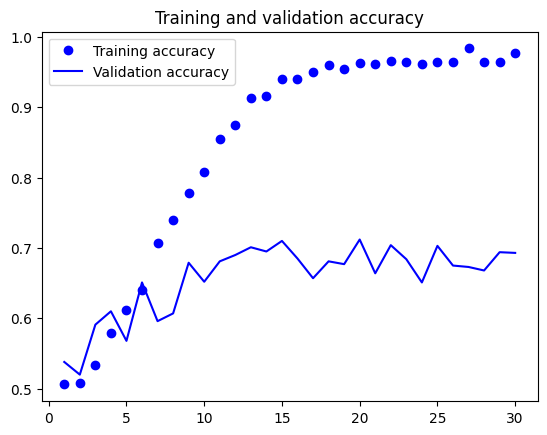

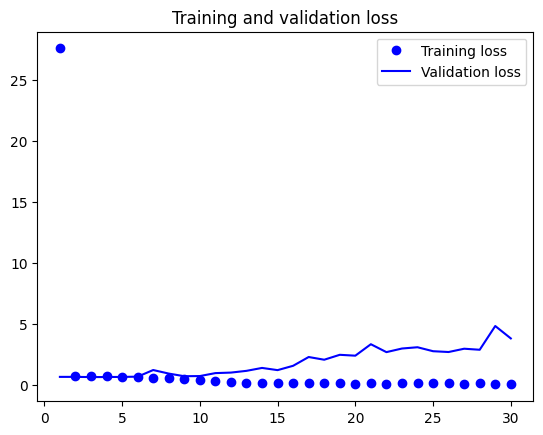

In [ ]:
import matplotlib.pyplot as plt
accuracy = hist.history["accuracy"]
val_accuracy = hist.history["val_accuracy"]
loss = hist.history["loss"]
val_loss = hist.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [ ]:
# evaluate
cd_model.evaluate(test_dataset)

63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.6766 - loss: 4.3077


[4.143946170806885, 0.6809999942779541]

***Add Data Augmentation***

In [ ]:
# adding data augmentation layer
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip('horizontal'),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2)
    ]
)

In [ ]:
# new model with data augmentation and DropOut to fight overfitting
inputs = keras.Input((180,180,3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation='relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation='relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation='relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation='relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation='relu')(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, 'sigmoid')(x)
cd_aug_model = keras.Model(inputs = inputs, outputs = outputs)


In [ ]:
# define call back and train
callbacks = [
    keras.callbacks.ModelCheckpoint(filepath='CNN_Aug_Drop_Colab.keras', save_best_only=True, monitor='val_loss')
]

# compile
cd_aug_model.compile(optimizer='rmsprop', loss = 'binary_crossentropy', metrics = ['accuracy'])

# Run
hist_aug_drop = cd_aug_model.fit(train_dataset,
                                 epochs = 100, # high epochs since overfitting is expected to occur later
                                 callbacks = callbacks,
                                 validation_data = validation_dataset)

Epoch 1/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 64ms/step - accuracy: 0.5034 - loss: 0.6963 - val_accuracy: 0.5740 - val_loss: 0.6922
Epoch 2/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 78ms/step - accuracy: 0.4957 - loss: 0.6941 - val_accuracy: 0.5250 - val_loss: 0.6921
Epoch 3/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.5361 - loss: 0.6913 - val_accuracy: 0.5020 - val_loss: 0.7292
Epoch 4/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.5569 - loss: 0.6938 - val_accuracy: 0.6170 - val_loss: 0.6531
Epoch 5/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - accuracy: 0.6298 - loss: 0.6508 - val_accuracy: 0.6550 - val_loss: 0.6087
Epoch 6/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - accuracy: 0.6666 - loss: 0.6368 - val_accuracy: 0.6330 - val_loss: 0.6235
Epoch 7/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.6474 - loss: 0.6313 - val_accuracy: 0.6470 - val_loss: 0.6028
Epoch 8/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - accuracy: 0.6772 - loss: 0.6142 - val_accuracy: 0.

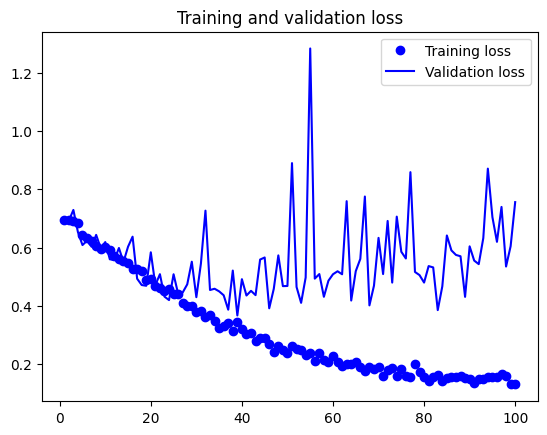

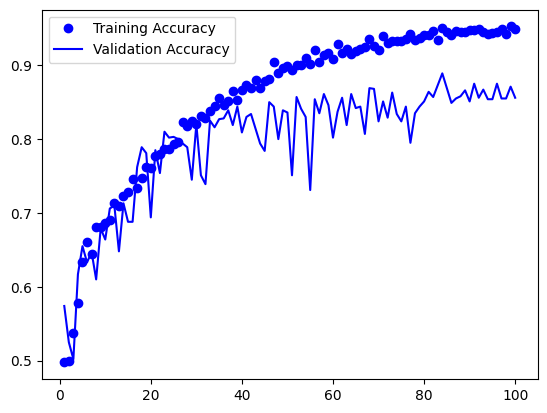

In [ ]:
# plotting loss and accuracy
accuracy = hist_aug_drop.history["accuracy"]
val_accuracy = hist_aug_drop.history["val_accuracy"]
loss = hist_aug_drop.history["loss"]
val_loss = hist_aug_drop.history["val_loss"]
epochs = range(1, len(hist_aug_drop.history['loss']) + 1)
plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()
plt.plot(epochs, accuracy, 'bo', label = 'Training Accuracy')
plt.plot(epochs, val_accuracy, 'b', label = 'Validation Accuracy')
plt.legend()
plt.show()


In [ ]:
# Load model
cd_aug_model = keras.models.load_model('CNN_Aug_Drop_Colab.keras')

In [ ]:
# evaluate
cd_aug_model.evaluate(test_dataset)

63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.8463 - loss: 0.3753


[0.4113743305206299, 0.828499972820282]

***Use Pre-trained Model***

In [10]:
# download model VGG16
from tensorflow.keras.applications import VGG16
vgg16_model = VGG16(weights = 'imagenet',
                    include_top = False,
                    input_shape = (180,180,3))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [11]:
# function to Extract features from VGG16
import numpy as np

def get_features_and_labels(dataset):
  all_features = []
  all_labels = []
  for images,labels in dataset:
    preprocessed_images = keras.applications.vgg16.preprocess_input(images)
    features = vgg16_model.predict(preprocessed_images)
    all_features.append(features)
    all_labels.append(labels)
  return np.concatenate(all_features), np.concatenate(all_labels)

In [ ]:
# Extract features
train_features, train_labels = get_features_and_labels(train_dataset)
val_features, val_labels = get_features_and_labels(validation_dataset)
test_features, test_labels = get_features_and_labels(test_dataset)
#

1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
1/1 ━━━━━━━━